In [122]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import uproot, os, pickle

In [123]:
N_data = 3 * 10 ** 3
features = "v0_chi2 v0_py1 v0_phi1 v0_px1 v0_px v0_px2 v0_phi2 v0_py \
v0_py2 pv0_y pv0_x ntrk_pv0 pv0_z v0_z v0_rxyErr a0xy \
a0 cosTheta v0_x v0_y v0_ks_mass".split(" ")

In [124]:
data_path = "../../Data/mc15_13TeV.361203.Pythia8_A2_MSTW2008LO_ND_minbias.30062015_v0_per_0.root"
data_file = uproot.open(data_path)
data_tree = data_file['tree']

df = data_tree.pandas.df(features, entrystop = N_data)

In [125]:
from scipy.spatial.distance import squareform

In [126]:
overwrite = False

if "MIC_matrix.dat" not in os.listdir() or overwrite == True: 
    from minepy import pstats
    MIC_corr_matrix = pstats(df.T)
    MIC_corr_matrix = squareform(MIC_corr_matrix[1])
    mic_df = pd.DataFrame(MIC_corr_matrix)
    mic_df.columns = features
    mic_df.to_pickle("MIC_matrix.dat")
else:
    mic_df = pd.read_pickle("MIC_matrix.dat")

In [127]:
from scipy.cluster.hierarchy import linkage, leaves_list, optimal_leaf_ordering, fcluster
cols_sort = features[:-1]
mat = mic_df.iloc[:-1, :-1]

dist = np.array(1 - mat)
for i in range(dist.shape[0]):
    dist[i, i] = 0

dist = squareform(dist)

Z = linkage(dist, method = "single", optimal_ordering = True)
sort_ind = np.append(leaves_list(optimal_leaf_ordering(Z, dist)), -1)
# sort_ind.append(-1)

cols_sort = np.array(features)[sort_ind]
sorted_mat = np.array(mic_df)[:, sort_ind]
sorted_mat = sorted_mat[sort_ind, :]

label = fcluster(Z, 0.8, criterion = 'distance')[sort_ind]
# cuts = np.arange(len(label))[(label - np.roll(label, 1) == 1)]
# cuts = np.hstack([0] + list(cuts) + [len(label)])
cuts = [0,  9, len(label) - 1, len(label)]

# cuts = [0, 16, len(label)]

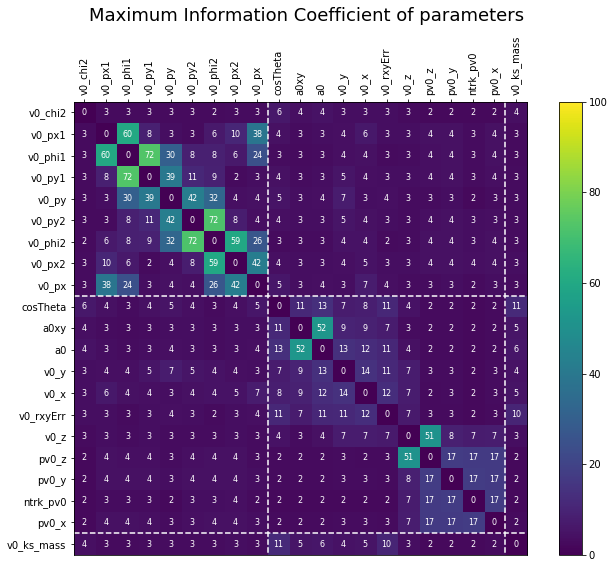

In [128]:
fig, ax = plt.subplots(figsize = (10, 8))
show = ax.imshow(sorted_mat * 100, vmin = 0, vmax = 100) 
cols = df.columns

ax.set_xticks(np.arange(len(cols_sort)))
ax.set_xticklabels(cols_sort, rotation = 90)
ax.set_yticks(np.arange(len(cols_sort)))
ax.set_yticklabels(cols_sort)
ax.tick_params(axis = 'x', bottom = False, top = True, labelbottom = False, labeltop = True)

fig.colorbar(show)

for i in range(sorted_mat.shape[1]):
    for j in range(sorted_mat.shape[0]):
        text = ax.text(j, i, int(np.array(sorted_mat * 100)[i, j]),
                       ha="center", va="center", color="w", fontsize = 8)


for line in cuts[1:-1]:#np.arange(len(label))[(label - np.roll(label, 1) == 1)] - 0.5:
        ax.hlines(line - 0.5, -0.5, len(sort_ind) - .5, color = 'white', linestyle = 'dashed')
        ax.vlines(line - 0.5, -0.5, len(sort_ind) - .5, color = 'white', linestyle = 'dashed')

fig.suptitle("Maximum Information Coefficient of parameters", fontsize = 18)
        
        
fig.tight_layout(rect = (0, 0, 1, 0.95))



In [146]:
features1 = cols_sort[1:10]

features2 = cols_sort[10:-1]

mass = cols_sort[-1]

In [147]:
features2

array(['a0xy', 'a0', 'v0_y', 'v0_x', 'v0_rxyErr', 'v0_z', 'pv0_z',
       'pv0_y', 'ntrk_pv0', 'pv0_x'], dtype='<U10')

In [148]:
Ndata = 10**6
test_ratio = 0.2

df1 = data_tree.pandas.df(features1, entrystop = Ndata)
df2 = data_tree.pandas.df(features2, entrystart = Ndata, entrystop = 2 * Ndata).reset_index(drop = True)

mass1 = data_tree.pandas.df(mass, entrystop = Ndata)
mass2 = data_tree.pandas.df(mass, entrystart = Ndata, entrystop = 2 * Ndata).reset_index(drop = True)

from sklearn.model_selection import train_test_split
df1_train, df1_test, mass1_train, mass1_test = train_test_split(df1, mass1, test_size = test_ratio)
df2_train, df2_test, mass2_train, mass2_test = train_test_split(df2, mass2, test_size = test_ratio)

In [149]:
mean, sig = 498.26, 7.005

from lightgbm import LGBMClassifier

# Apply range
mass = mass1_train[(mass1_train > 400) & (mass1_train < 600)].dropna()

pseudo_true = mass[abs(mass - mean) <  sig].dropna()

am = len(pseudo_true)

# True false
low_false = mass[(mass  + 7 * sig < mean)|(mass  + 10 * sig > mean)].dropna().sample(am)
high_false = mass[(mass  - 10 * sig > mean)|(mass  - 7 * sig < mean)].dropna().sample(am)

# Make df
indicies = pd.concat([pseudo_true, low_false, high_false]).index

target1 = pd.Series(np.zeros(len(indicies), dtype = int), indicies, dtype = bool)
target1.loc[pseudo_true.index] = 1

model1 = LGBMClassifier()
model1.fit(df1_train.loc[target1.index, :], target1.astype(bool))

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [150]:
# Apply range
mass = mass2_train[(mass2_train > 400) & (mass2_train < 600)].dropna()

pseudo_true = mass[abs(mass - mean) <  sig].dropna()

am = len(pseudo_true)

# True false
low_false = mass[(mass  + 7 * sig < mean)|(mass  + 10 * sig > mean)].dropna().sample(am)
high_false = mass[(mass  - 10 * sig > mean)|(mass  - 7 * sig < mean)].dropna().sample(am)

# Make df
indicies = pd.concat([pseudo_true, low_false, high_false]).index

target2 = pd.Series(np.zeros(len(indicies), dtype = int), indicies, dtype = bool)
target2.loc[pseudo_true.index] = 1

model2 = LGBMClassifier()
model2.fit(df2_train.loc[target2.index, :], target2.astype(bool))

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [220]:
import sys
sys.path.append("../py_files")
import functions as f
import importlib
importlib.reload(f)

<module 'functions' from '../py_files/functions.py'>

AUC estimate = -0.0390


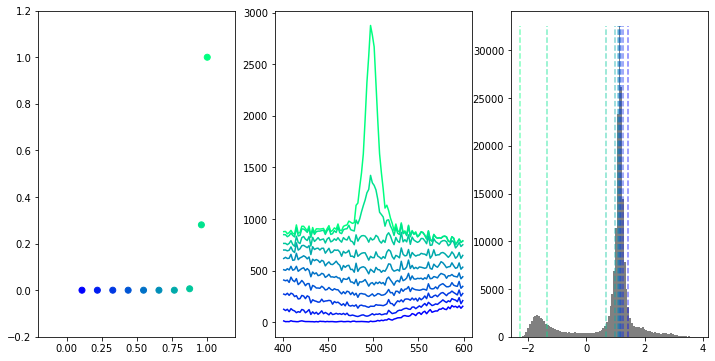

In [221]:
fig, ax = plt.subplots(ncols = 3, figsize = (12, 6))

probs1 = model1.predict_proba(df1_test)
from scipy.special import logit
# ax[2].hist(logit(probs1[:, 0]))

f.roc_curve_data(mass1_test, probs1[:, 0], ax_roc = ax[0], ax_fits = ax[1], Npoints = 10, \
                 plimit = 0, verbose = False, ax_hist = ax[2])

No valid minimum found!
AUC estimate = -0.0318


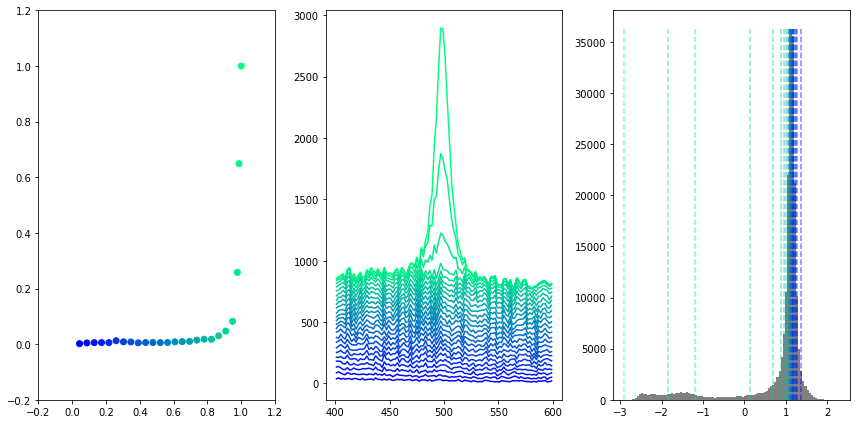

In [223]:
fig, ax = plt.subplots(ncols = 3, figsize = (12, 6))

probs2 = model2.predict_proba(df2_test)
from scipy.special import logit
# ax[2].hist(logit(probs2[:, 0]))

f.roc_curve_data(mass2_test, probs2[:, 0], ax_roc = ax[0], ax_fits = ax[1], Npoints = 25, verbose = False,ax_hist = ax[2])
fig.tight_layout()